In [1]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, transpile, assemble
from qiskit.circuit import Parameter
import math
import random
import numpy as np
import copy
import time
from scipy.optimize import minimize
from qiskit.quantum_info.operators import Operator
from typing import Optional, List, Dict, Tuple, Union
from qiskit.result import Counts, Result

from qiskit import pulse, IBMQ
from qiskit.pulse.schedule import ScheduleBlock
from qiskit.pulse import Schedule
from qiskit.pulse.instructions import Call
from qiskit import transpile, schedule as build_schedule
from qiskit.providers.aer.pulse import duffing_system_model


import logging
logger = logging.getLogger()

# imports for qiskit dynamics simulation
from matplotlib import pyplot as plt
from qiskit_dynamics.pulse import InstructionToSignals
from qiskit.quantum_info.operators import Operator
from qiskit_dynamics import Solver
from qiskit.quantum_info.states import Statevector

# optimizers
import random
from scipy.optimize import fmin_l_bfgs_b
from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import QNSPSA

from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper, BravyiKitaevMapper
# Solvers
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_nature.algorithms import GroundStateEigensolver

# for HF calculation
from pyscf import scf
from pyscf import gto


Numpy 1.16 has memory leak bug  https://github.com/numpy/numpy/issues/13808
It is recommended to downgrade to numpy 1.15 or older


# Define the system (backend and noise)

In [ ]:
IBMQ.ibmq.load_account()

In [5]:
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend_manila = provider.get_backend('ibmq_manila')
manila_prop = backend_manila.properties()

In [ ]:
# build the noise model
import qiskit_aer
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

t1 = 100e3
t2 = 100e3

noise_thermal = qiskit_aer.noise.NoiseModel.from_backend(backend_manila, gate_error=True, thermal_relaxation=False,
                                                      readout_error=False)

for i in range(5):
    noise_thermal.add_quantum_error(thermal_relaxation_error(t1, t2, 1e9 * manila_prop.gate_length('reset', i)),
                                    "reset", [i])
    noise_thermal.add_quantum_error(thermal_relaxation_error(t1, t2, 1e9 * manila_prop.gate_length('id', i)),
                                    "id", [i])
    noise_thermal.add_quantum_error(thermal_relaxation_error(t1, t2, 1e9 * manila_prop.gate_length('sx', i)),
                                    "sx", [i])
    noise_thermal.add_quantum_error(thermal_relaxation_error(t1, t2, 1e9 * manila_prop.gate_length('x', i)),
                                    "x", [i])
    for j in range(5):
        try:
            noise_thermal.add_quantum_error(
                thermal_relaxation_error(t1, t2, 1e9 * manila_prop.gate_length('cx', [i,j])).expand(
                    thermal_relaxation_error(t1, t2, 1e9 * manila_prop.gate_length('cx', [i,j]))),
                                            "cx", [i, j])
        except:
            pass


# Define functions to run the simulation

In [9]:
def run_ansatz(circ, noise):
    sim_backend = AerSimulator(noise_model=noise)
    circ.snapshot('final', snapshot_type='density_matrix')
    circ_tthermal = transpile(circ, sim_backend, optimization_level=0)
    
    job = sim_backend.run(circ_tthermal)
    density_matrix_res = job.result().data(0)['snapshots']['density_matrix']['final'][0]['value']
    return density_matrix_res

In [10]:
# define relevant functions
def expval_with_variance(counts,
                         operator_coeff: int,
                         diagonal: Optional[np.ndarray] = None,
                        finite_sampling=True) -> Tuple[float, float]:
    r"""Compute the expectation value of a diagonal operator from counts.

    Args:
        counts: counts object.
        diagonal: Optional, values of the diagonal observable. If None the
                  observable is set to :math:`Z^\otimes n`.

    Returns:
        (float, float): the expectation value and variance.
    """
    if finite_sampling:
        # Get counts shots and probabilities
        probs = np.array(list(counts.values()))
        shots = probs.sum()
        probs = probs / shots
        
        # Get diagonal operator coefficients
        if diagonal is None:
            coeffs = np.array([(-1) ** (key.count('1') % 2)
                               for key in counts.keys()])
        else:
            keys = [int(key, 2) for key in counts.keys()]
            coeffs = np.asarray(diagonal[keys])
            
        # Compute expval
        expval = coeffs.dot(probs)
        
        # Compute variance
        if diagonal is None:
            # The square of the parity diagonal is the all 1 vector
            sq_expval = np.sum(probs)
        else:
            sq_expval = (coeffs ** 2).dot(probs)
        variance = (sq_expval - expval ** 2) / shots
    else:
        probs = counts

        # Get diagonal operator coefficients
        if diagonal is None:
            coeffs = np.array([(-1) ** (key.count('1') % 2)
                               for key in probs.keys()])
        else:
            keys = [int(key, 2) for key in probs.keys()]
            coeffs = np.asarray(diagonal[keys])

        # Compute expval
        expval = coeffs.dot(list(probs.values()))

        # Compute variance
        if diagonal is None:
            # The square of the parity diagonal is the all 1 vector
            sq_expval = np.sum(list(probs.values()))
        else:
            sq_expval = (coeffs ** 2).dot(list(probs.values()))
        variance = (sq_expval - expval ** 2)# / shots

    # Compute standard deviation
    if variance < 0:
        if not np.isclose(variance, 0):
            logger.warning(
                'Encountered a negative variance in expectation value calculation.'
                '(%f). Setting standard deviation of result to 0.', variance)
        variance = 0.0
    return expval * operator_coeff, variance * abs(operator_coeff) ** 2

def calculate_accumulate_exp_val(probs, coeffs, finite_sampling):
    combined_expval = 0.0
    combined_variance = 0.0
    if type(probs) != list:
        probs = [probs]
    for ind, result in enumerate(probs):
        exp_val, exp_var = expval_with_variance(result, coeffs[ind], finite_sampling=finite_sampling)
        # Accumulate
        combined_expval += exp_val
        combined_variance += exp_var
    combined_stddev = np.sqrt(combined_variance)
    return combined_expval, combined_stddev

In [11]:
from qiskit.result import marginal_counts
hadamard = (1 / np.sqrt(2)) * np.array([[1,1],[1,-1]])
s_dg = np.array([[1,0],[0,1j]])
identity = np.array([[1,0],[0,1]])

def finite_sampling_measure(state, paulis, coeffs, leakage=False, shots=10000):
    ansatz_density_matrix = qiskit.quantum_info.DensityMatrix(state)
    if leakage:
        # filter out leakage
        reduced_density_matrix = qiskit.quantum_info.DensityMatrix(
            [list(ansatz_density_matrix.data[0][0:2]) + list(ansatz_density_matrix.data[0][3:5]),
             list(ansatz_density_matrix.data[1][0:2]) + list(ansatz_density_matrix.data[1][3:5]),
             list(ansatz_density_matrix.data[3][0:2]) + list(ansatz_density_matrix.data[3][3:5]),
             list(ansatz_density_matrix.data[4][0:2]) + list(ansatz_density_matrix.data[4][3:5])])
        leakage_prob = 1 - sum(reduced_density_matrix.probabilities())
        print("leakage percent: " + str(leakage_prob*100) + "%")
        ansatz_density_matrix = reduced_density_matrix / reduced_density_matrix.trace()

    # apply rotations to the result state
    results = [] 
    for pauli in paulis:
        measure_op = 1
        marginal_qubits = None
        for i, val in enumerate(reversed(pauli)):
            if val == 'Y':
                cur_measure_op = hadamard @ s_dg
                measure_op = np.kron(cur_measure_op, measure_op)
            if val == 'X':
                cur_measure_op = hadamard
                measure_op = np.kron(cur_measure_op, measure_op)
            if val == 'Z':
                cur_measure_op = identity
                measure_op = np.kron(cur_measure_op, measure_op)
            if val == 'I': # we calculate expectation value, so we do not need to measure the identity
                cur_measure_op = identity
                measure_op = np.kron(cur_measure_op, measure_op)
                marginal_qubits = 1 - i

        measured_density_matrix = ansatz_density_matrix.evolve(measure_op)

        if shots is not None:
            counts = measured_density_matrix.sample_counts(shots)
            if marginal_qubits is not None:
                counts = marginal_counts(counts, [marginal_qubits])
            results.append(counts)
            finite_sampling = True
        else:
            probs = measured_density_matrix.probabilities_dict()
            if marginal_qubits is not None:
                probs = marginal_counts(probs, [marginal_qubits])
            results.append(probs)
            finite_sampling=False
    
    expval, stddev = calculate_accumulate_exp_val(results, coeffs, finite_sampling)
    return expval, stddev

In [12]:
def evaluate_energy(theta, paulis, coeffs, noise_model, num_of_qubits, num_of_layers, shots=None):
    ansatz_circ = ansatz(num_of_qubits, num_of_layers)
    binded_circ = ansatz_circ.bind_parameters(theta)
        
    print(theta)
    ansatz_result = run_ansatz(binded_circ, noise_model)
    expval, stddev = finite_sampling_measure(ansatz_result, paulis[1:], coeffs[1:], leakage=False, shots=shots)
    print("energy: " + str(expval + coeffs[0]))
    # in case I will want to return also the varience
    # return expval, stddev
    
    # save in global variables the mid-optimization values
    thetas.append(copy.deepcopy(theta))
    values.append(expval)
    states.append(ansatz_result)
    return expval.real

In [13]:
def calculate_energy(theta):
    paulis = all_paulis[-1]
    coeffs = all_coeffs[-1]
    noise_model = noise_thermal
    num_of_qubits = 2
    num_of_layers = 1
    shots = 10000
    energy = evaluate_energy(theta, paulis, coeffs, noise_model, num_of_qubits, num_of_layers, shots)
    return energy

## Define the ansatz

In [14]:
def ansatz(num_of_qubits, num_of_layers):
    circ = QuantumCircuit(num_of_qubits)
    counter = 0
    for i in range(num_of_qubits):
        circ.ry(Parameter('θ_' + str(counter)), i)
        counter += 1
    for layer in range(num_of_layers):
        # alternating entangling layer
        for i in range(0, num_of_qubits-1, 2):
            circ.cx(i, i+1)
        for i in range(1, num_of_qubits-1, 2):
            circ.cx(i, i+1)
        for i in range(num_of_qubits):
            circ.ry(Parameter('θ_' + str(counter)), i)
            counter += 1
    return circ

# Functions to build the problem parameters

In [15]:
def get_qubit_op(dist, mapper="parity"):
    molecule = Molecule(geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, dist]]], charge=0, multiplicity=1)
    driver = ElectronicStructureMoleculeDriver(
        molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF)
    es_problem = ElectronicStructureProblem(driver)
    second_q_op = es_problem.second_q_ops()
    if mapper == "parity":
        qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
    elif mapper == "jordan":
        qubit_converter = QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=True)
    elif mapper == "bravi":
        qubit_converter = QubitConverter(mapper=BravyiKitaevMapper(), two_qubit_reduction=True)
    else:
        print("mapper should be one of parity, jordan or bravi")
        return None
    qubit_op = qubit_converter.convert(second_q_op[0], num_particles=es_problem.num_particles)
    return qubit_op, es_problem

In [16]:
def get_hf_energy(dist):
    temp_mol = gto.M(atom = 'H 0 0 0; H 0 0 ' + str(dist), basis = 'sto3g')
    temp_hf = scf.HF(temp_mol)
    return temp_hf.kernel()

In [17]:
def get_accurate_state(dist):
    temp_qubit_op = get_qubit_op(dist)[0]
    eigen_values, eigen_vectors = np.linalg.eigh(temp_qubit_op.to_matrix())
    min_eigen_value = eigen_values[0]
    min_eigen_vector = eigen_vectors.transpose()[0]
    return min_eigen_value, min_eigen_vector

In [18]:
def get_exact_energies(dist):
    numpy_solver = NumPyMinimumEigensolver()
    qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
    calc = GroundStateEigensolver(qubit_converter, numpy_solver)
    _, es_prob = get_qubit_op(dist)
    temp_res = calc.solve(es_prob)
    return temp_res, temp_res.total_energies[0], temp_res.nuclear_repulsion_energy

In [19]:
def get_paulis_and_coeffs(dist):
    qubit_op = get_qubit_op(dist)[0]
    paulis = []
    for op in qubit_op:
        paulis.append(str(op)[-op.num_qubits:])
    return paulis, qubit_op.coeffs

# Visualisation functions

In [20]:
def plot_convergence(values_hist_arr, dist):
    values_hist_arr_real = np.array(values_hist_arr[dist])
    paulis, coeffs = get_paulis_and_coeffs(dist)
    values_hist_arr_real = values_hist_arr_real + coeffs[0]
    values_hist_arr_real = np.array([spsa_value.real for spsa_value in values_hist_arr_real])
    
    temp_res, min_energy, nuclear_repulsion_energy = get_exact_energies(dist)
    min_eigenvalue = min_energy - nuclear_repulsion_energy

    fig = plt.figure(figsize=(8, 5))
    plt.plot(list(range(len(values_hist_arr[dist]))), values_hist_arr_real , lw=3, label="energy")
    plt.plot(list(range(len(values_hist_arr[dist]))), [min_eigenvalue] * len(values_hist_arr_real) , 'k', lw=3, 
             label="optimal energy", linestyle="dashed")
    plt.xlabel("iteration")
    plt.ylabel("Energy")
    plt.legend(frameon=False)
    plt.title("H_2 SPSA convergence")
    plt.show()

In [21]:
def plot_energies(energies, calculated_energies, distances):
    fig = plt.figure(figsize=(8, 5))
    plt.plot(distances, energies, lw=3, label="Exact Energy")
    plt.plot(distances, calculated_energies, lw=3, label="VQE Energy")
    plt.fill_between(distances, np.array(energies)-0.0016, np.array(energies)+0.0016, 
                     alpha=0.2, facecolor='#089FFF', label="Chemical accuracy")
    plt.xlabel('Atomic distance (Angstrom)')
    plt.ylabel('Energy')
    plt.legend()
    plt.show()

In [22]:
def plot_energies_error(energies, calculated_energies, distances):
    fig = plt.figure(figsize=(8, 5))
    plt.plot(distances, np.abs(np.array(energies) - np.array(calculated_energies)), lw=3, label="Energy Error")
    plt.axhline(0.0016, linestyle='--', label="Chemical accuracy")
    plt.xlabel('Atomic distance (Angstrom)')
    plt.ylabel('Energy Error')
    plt.legend()
    plt.show()

# Run the simulation

In [158]:
from qiskit.algorithms.optimizers import SPSA

dists = [0.3, 0.5, 0.7, 0.8, 1, 1.5, 2, 3]

thetas_hist = {}
values_hist = {}
states_hist = {}
all_paulis = []
all_coeffs =[]

for dist in dists:
    print("#########################################")
    print("Solving for distance " + str(dist) + ":")
    print("#########################################")
    paulis, coeffs = get_paulis_and_coeffs(dist)
    all_paulis.append(paulis)
    all_coeffs.append(coeffs)
    temp_res, min_energy, nuclear_repulsion_energy = get_exact_energies(dist)
    target_energy = min_energy - nuclear_repulsion_energy

    initial_theta = [np.pi, 0, 0, 0]

    thetas = []
    values = []
    states = []

    tic = time.perf_counter()
    spsa = SPSA(maxiter=200)#, learning_rate=learning_rate, perturbation=perturbation)
    vqe_result = spsa.minimize(calculate_energy, initial_theta)
    toc = time.perf_counter()

    thetas_hist[dist] = copy.deepcopy(thetas)
    values_hist[dist] = copy.deepcopy(values)
    states_hist[dist] = copy.deepcopy(states)

    opt_theta_index = values.index(np.min(values))

    print(f"Finished the VQE in {toc - tic:0.4f} seconds")
    print("final theta: " + str(thetas[opt_theta_index]))
    res = min(values).real + coeffs[0]
    print("min eigen_value found: " + str(res))
    print("absolute error: " + str(np.abs(res - target_energy)))
    print("number of function evaluations: " + str(vqe_result.nfev))
#     opt_sched = ansatz_gate_inspired_weighted(thetas[opt_theta_index], dt)
#     print("solution schedule duration: " + str(opt_sched.duration * dt) + " [ns]")

#########################################
Solving for distance 0.3:
#########################################
[ 2.94159265  0.2        -0.2         0.2       ]
energy: (-0.7229319218403076+0j)
[ 3.34159265 -0.2         0.2        -0.2       ]
energy: (-0.7864476123763996+0j)
[ 2.94159265  0.2        -0.2         0.2       ]
energy: (-0.7250821199244544+0j)
[ 3.34159265 -0.2         0.2        -0.2       ]
energy: (-0.7929031347140032+0j)
[ 2.94159265 -0.2         0.2         0.2       ]
energy: (-0.7611352983760195+0j)
[ 3.34159265  0.2        -0.2        -0.2       ]
energy: (-0.8226058356233845+0j)
[ 2.94159265  0.2        -0.2        -0.2       ]
energy: (-0.7576106991036166+0j)
[ 3.34159265 -0.2         0.2         0.2       ]
energy: (-0.8335657799114136+0j)
[ 3.34159265 -0.2         0.2        -0.2       ]
energy: (-0.7932415672142312+0j)
[ 2.94159265  0.2        -0.2         0.2       ]
energy: (-0.71951774036047+0j)
[ 2.94159265 -0.2         0.2        -0.2       ]
energy: (-0.

energy: (-1.964567255150675+0j)
[-0.42130309 -1.82780352  2.5610812   7.03864564]
energy: (-1.9652684665434337+0j)
[-0.4222457  -1.82874614  2.56013859  7.03958826]
energy: (-1.9522252565159235+0j)
[-0.13550308 -1.54200352  2.84688121  6.75284564]
energy: (-1.9552820561131286+0j)
[-0.12965435 -1.53615478  2.85272994  6.7469969 ]
energy: (-1.9438957153105565+0j)
[-0.41534565 -1.82184609  2.56703863  7.03268821]
energy: (-1.9406893105324532+0j)
[-0.40827463 -1.81477507  2.57410966  7.02561719]
energy: (-1.9473341526486028+0j)
[-0.12359408 -1.53009452  2.85879021  6.74093664]
energy: (-1.955934850368992+0j)
[-0.39048365 -1.51327664  2.59190063  7.00782621]
energy: (-2.1075704001680853+0j)
[-0.1067762  -1.79698409  2.87560809  6.72411876]
energy: (-1.7511946478090583+0j)
[-0.8121905  -1.09156979  1.88742436  7.71230249]
energy: (-2.0430448248079736+0j)
[-1.09495993 -0.80880036  2.17019379  7.42953305]
energy: (-1.9009449969220797+0j)
[-0.536136   -1.3676243   1.89323401  7.98835699]
energy

energy: (-2.2861960859127155+0j)
[-0.09238284 -1.7261175   3.05008159  8.23354966]
energy: (-2.2850976123058864+0j)
[-0.34965906 -1.98339372  2.79280536  7.97627344]
energy: (-2.2915154006200513+0j)
[-0.35731128 -1.73409637  3.04210272  8.2255708 ]
energy: (-2.2822181966394677+0j)
[-0.10036171 -1.99104594  2.78515314  7.96862122]
energy: (-2.260355278369256+0j)
[-0.38360746 -1.96442758  2.81177151  7.99523959]
energy: (-2.28083864183951+0j)
[-0.12698007 -1.70780019  3.0683989   8.25186697]
energy: (-2.2823356794859904+0j)
[-0.1253386  -1.96246827  2.81373082  8.25350845]
energy: (-2.2854848659271223+0j)
[-0.38164815 -1.70615872  3.07004037  7.99719889]
energy: (-2.280514552249949+0j)
[-0.37555051 -1.71225636  3.06394273  8.00329654]
energy: (-2.2787204463583417+0j)
[-0.11955455 -1.96825231  2.80794677  8.25929249]
energy: (-2.283966880967317+0j)
[-0.36916286 -1.718644    3.05755508  8.00968418]
energy: (-2.2844380848326913+0j)
[-0.11347637 -1.9743305   2.80186859  8.26537067]
energy: (

energy: (-2.288837468607062+0j)
[-0.39995688 -1.94696394  2.75064461  7.92908561]
energy: (-2.2839891844554012+0j)
[-0.39524329 -1.94225035  3.00001185  8.17845285]
energy: (-2.286274366588131+0j)
[-0.15058964 -1.69759669  2.7553582   7.9337992 ]
energy: (-2.2844056812611346+0j)
[-0.15245738 -1.69946444  3.00169032  7.93566694]
energy: (-2.3046284065884537+0j)
[-0.39692176 -1.94392882  2.75722594  8.18013133]
energy: (-2.3074839669236455+0j)
[-0.15525036 -1.9465341   2.99889735  8.18273661]
energy: (-2.3080167909583826+0j)
[-0.39952705 -1.70225741  2.75462066  7.93845992]
energy: (-2.3144338765845163+0j)
[-0.1613859 -1.696308   2.9927618  7.9325105]
energy: (-2.3115980352826977+0j)
[-0.40547646 -1.94039855  2.74867125  8.17660106]
energy: (-2.3025998805997228+0j)
[-0.39694326 -1.93186535  3.0011104   8.16806786]
energy: (-2.292581450173052+0j)
[-0.1530373  -1.6879594   2.75720445  7.9241619 ]
energy: (-2.2887869303140427+0j)
[-0.40039791 -1.69159713  2.76084218  7.92779964]
energy: (-2

energy: (-2.292064788963925+0j)
[-0.17998542 -1.85032763  2.99934927  7.85453713]
energy: (-2.2840746851445424+0j)
[-0.18645617 -1.84385688  2.99287852  8.09735615]
energy: (-2.3087161619172516+0j)
[-0.42280444 -1.6075086   2.75653024  7.86100788]
energy: (-2.3109795146345062+0j)
[-0.18833066 -1.84198239  2.75478581  7.85926345]
energy: (-2.2798652624266076+0j)
[-0.42454887 -1.60576417  2.99100403  8.09548167]
energy: (-2.271818505318553+0j)
[-0.18197977 -1.84833327  2.74843492  7.85291256]
energy: (-2.2778075560249844+0j)
[-0.41806871 -1.61224433  2.98452386  8.0890015 ]
energy: (-2.282105048110778+0j)
[-0.18546104 -1.60889157  2.75191619  7.85639383]
energy: (-2.2937128411394436+0j)
[-0.42142147 -1.844852    2.98787663  8.09235426]
energy: (-2.291446399777696+0j)
[-0.41956037 -1.8429909   2.75018284  8.09049316]
energy: (-2.3136870908005713+0j)
[-0.18372769 -1.60715822  2.98601552  7.85466048]
energy: (-2.314136237149996+0j)
[-0.18343598 -1.84257219  2.75060155  8.09007445]
energy: (

energy: (-1.7132398241705173+0j)
[ 2.88370412 -0.25788854  4.95663465 -9.41024646]
energy: (-1.5649589782082787+0j)
[ 3.80800033  0.66640767  5.55670481 -8.48595025]
energy: (-1.7853380830656271+0j)
[ 3.48377428  0.34218163  5.88093086 -8.8101763 ]
energy: (-1.866574956081364+0j)
[ 3.49973161  0.03774707  6.18536541 -8.79421897]
energy: (-1.8074873327187406+0j)
[ 3.17933973  0.35813895  5.86497353 -9.11461085]
energy: (-1.964967189273969+0j)
[ 2.62119453  0.91628415  5.62382886 -9.35575552]
energy: (-1.601455759333394+0j)
[ 2.93819506  0.59928362  5.30682833 -9.67275605]
energy: (-1.6282215855739108+0j)
[ 2.71297307  0.82450561  5.2180867  -9.44753406]
energy: (-1.4569707913376857+0j)
[ 3.02693669  0.51054199  5.53205032 -9.76149768]
energy: (-1.740449259060989+0j)
[  3.62572228  -0.39946015   6.13083591 -10.36028327]
energy: (-1.7932172709023413+0j)
[  3.93693883  -0.08824359   6.44205246 -10.67149982]
energy: (-1.4147487462816446+0j)
[ 2.46211165 -1.56307077  5.275936   -9.19667264]


energy: (-2.0157803839366055+0j)
[  3.69668879  -1.92440276   7.09788985 -11.04482788]
energy: (-2.013313672501961+0j)
[  3.966847    -1.92061927   7.09410636 -11.31498608]
energy: (-2.0384321721145144+0j)
[  3.70047228  -1.65424455   6.82773164 -11.04861136]
energy: (-2.033547319205794+0j)
[  3.70765919  -1.66143147   6.83491856 -11.32169723]
energy: (-2.0283826527991837+0j)
[  3.97355815  -1.92733042   7.10081751 -11.05579828]
energy: (-2.027267430113654+0j)
[  3.70632005  -1.92552462   6.83357941 -11.05760408]
energy: (-2.0226399087210796+0j)
[  3.97175235  -1.66009232   7.09901171 -11.32303638]
energy: (-2.0295429477721343+0j)
[  3.7161979   -1.65067236   7.10843167 -11.06748193]
energy: (-2.0265036481575027+0j)
[  3.98117231  -1.91564677   6.84345726 -11.33245634]
energy: (-2.0206442549755095+0j)
[  3.97282732  -1.64277679   6.85180224 -11.05958636]
energy: (-2.020531369660671+0j)
[  3.70830233  -1.90730179   7.11632724 -11.32411135]
energy: (-2.018159106743203+0j)
[  3.97586675  

energy: (-2.047967895992591+0j)
[  4.02517396  -1.66662713   7.17563196 -11.05116882]
energy: (-2.0454990960341934+0j)
[  3.77274194  -1.91905915   6.92319994 -11.30360084]
energy: (-2.0438344436495255+0j)
[  4.02249114  -1.66930996   7.17294914 -11.05385164]
energy: (-2.0461941901354095+0j)
[  3.7752987   -1.9165024    7.17526915 -11.30104409]
energy: (-2.028873037653977+0j)
[  4.02481115  -1.66698994   6.92575669 -11.05153163]
energy: (-2.022654904383363+0j)
[  3.76902066  -1.6735023    7.18154719 -11.05804398]
energy: (-2.023367534611446+0j)
[  4.0182988   -1.92278043   6.93226905 -11.30732212]
energy: (-2.0247466699904577+0j)
[  3.77054844  -1.67503008   7.18001941 -11.05957177]
energy: (-2.0289007385510613+0j)
[  4.01959464  -1.92407628   6.93097321 -11.30861796]
energy: (-2.0274232369260208+0j)
[  3.76915771  -1.67363934   7.18141014 -11.30699762]
energy: (-2.001949865088012+0j)
[  4.01797429  -1.92245593   6.93259355 -11.05818103]
energy: (-2.005801277548435+0j)
[  4.02176722  -

energy: (-2.019608364475828+0j)
[  3.74437965  -1.9098705    7.12824559 -11.07632744]
energy: (-2.0200157740835287+0j)
[  3.98445487  -1.66979528   6.88817037 -11.07605688]
energy: (-2.0218202030638253+0j)
[  3.74410909  -1.91014106   7.12851614 -11.31640266]
energy: (-2.0289916115552074+0j)
[  3.97825103  -1.91618884   7.13456392 -11.32245044]
energy: (-2.0374284129214972+0j)
[  3.73806131  -1.67599912   6.89437421 -11.08226072]
energy: (-2.0352559625058597+0j)
[  3.73998853  -1.67792634   6.89630142 -11.32422269]
energy: (-2.0327183454496414+0j)
[  3.98002328  -1.91796109   7.13633618 -11.08418794]
energy: (-2.033191953378841+0j)
[  3.74046743  -1.67840524   6.89678033 -11.32374379]
energy: (-2.0250708503255552+0j)
[  3.98034831  -1.91828612   7.1366612  -11.08386291]
energy: (-2.0349410990111263+0j)
[  3.74889441  -1.92656028   6.9052073  -11.07558875]
energy: (-2.0310619753619505+0j)
[  3.98862247  -1.68683221   7.14493537 -11.31531681]
energy: (-2.0335882775924237+0j)
[  3.9906771

[ 2.94159265  0.2         0.2        -0.2       ]
energy: (-1.0565506666912703+0j)
[ 3.34159265 -0.2        -0.2         0.2       ]
energy: (-1.1129767657409815+0j)
[ 3.34159265 -0.2         0.2         0.2       ]
energy: (-1.1036168729146139+0j)
[ 2.94159265  0.2        -0.2        -0.2       ]
energy: (-1.0336366458665198+0j)
[ 3.34159265 -0.2        -0.2        -0.2       ]
energy: (-1.0791028633187265+0j)
[2.94159265 0.2        0.2        0.2       ]
energy: (-1.024314082155311+0j)
[ 3.34159265 -0.2        -0.2        -0.2       ]
energy: (-1.0758886204563287+0j)
[2.94159265 0.2        0.2        0.2       ]
energy: (-1.0162416877277844+0j)
[ 2.94159265 -0.2         0.2         0.2       ]
energy: (-1.029745639382915+0j)
[ 3.34159265  0.2        -0.2        -0.2       ]
energy: (-1.097637377229646+0j)
[ 3.34159265  0.2        -0.2         0.2       ]
energy: (-1.0807875294890852+0j)
[ 2.94159265 -0.2         0.2        -0.2       ]
energy: (-1.0128017188930316+0j)
[ 2.94159265  0

energy: (-1.8356383967842107+0j)
[ 0.20111246  1.48657985  3.22813215 -1.75431947]
energy: (-1.8069239731337245+0j)
[-0.08356809  1.7712604   2.9434516  -1.46963892]
energy: (-1.8100289894650659+0j)
[-0.08879121  1.49277607  2.93822848 -1.74812326]
energy: (-1.8336145015371854+0j)
[ 0.19491625  1.77648352  3.22193593 -1.4644158 ]
energy: (-1.8232521108870738+0j)
[-0.1070562   1.75728051  2.91996349 -1.48361881]
energy: (-1.8044134154046545+0j)
[ 0.17571323  1.47451108  3.20273292 -1.76638825]
energy: (-1.8116621063201723+0j)
[ 0.18815186  1.46207245  2.9333074  -1.77882688]
energy: (-1.8327105006977211+0j)
[-0.09371229  1.7439366   3.21517155 -1.49696273]
energy: (-1.839561851257944+0j)
[ 0.17572218  1.75549162  2.94573708 -1.7663972 ]
energy: (-1.8450715173007837+0j)
[-0.10526731  1.47450213  3.22672657 -1.4854077 ]
energy: (-1.848258223000271+0j)
[-0.1103369   1.46943254  3.23179616 -1.76048166]
energy: (-1.8347321403731378+0j)
[ 0.16980665  1.74957609  2.95165261 -1.48033812]
energy

energy: (-1.8491427890408696+0j)
[-0.13184448  1.40898305  3.27866006 -1.4008359 ]
energy: (-1.8476620185821355+0j)
[ 0.12446508  1.6652926   3.02235051 -1.65714545]
energy: (-1.8506915602722378+0j)
[-0.12837816  1.41244937  3.27519375 -1.66029817]
energy: (-1.8360328540034923+0j)
[ 0.12761779  1.66844532  3.01919779 -1.40430222]
energy: (-1.8380713397470876+0j)
[ 0.12967645  1.67050398  3.27282563 -1.40224356]
energy: (-1.8337379788670294+0j)
[-0.12601004  1.41481749  3.01713914 -1.65793005]
energy: (-1.8333127464917616+0j)
[ 0.12998269  1.41542916  3.27313187 -1.40193732]
energy: (-1.837808140825378+0j)
[-0.12539837  1.67081022  3.01775081 -1.65731838]
energy: (-1.8405068981299344+0j)
[ 0.12693637  1.41847548  3.27008555 -1.40498364]
energy: (-1.8437274637780598+0j)
[-0.12814318  1.67355503  3.015006   -1.66006319]
energy: (-1.8381901805863667+0j)
[-0.12208797  1.41271793  3.02106121 -1.65400798]
energy: (-1.8322232013324202+0j)
[ 0.13269392  1.66749982  3.27584309 -1.39922609]
energ

energy: (-1.8359980766109043+0j)
[-0.06679421  1.56955428  2.97732124 -1.30949629]
energy: (-1.8221475800729432+0j)
[ 0.17748248  1.32527759  3.22159792 -1.55377298]
energy: (-1.8264096535802232+0j)
[-0.06303321  1.32170272  2.98108224 -1.3132573 ]
energy: (-1.8419343003939255+0j)
[ 0.18105735  1.56579328  3.22517279 -1.55734785]
energy: (-1.832973847363038+0j)
[ 0.1732828   1.55801872  2.97349228 -1.30566734]
energy: (-1.8429693857963474+0j)
[-0.07062316  1.31411277  3.21739824 -1.5495733 ]
energy: (-1.833077762150134+0j)
[-0.06208279  1.32265314  2.965135   -1.54103293]
energy: (-1.8358327644795012+0j)
[ 0.18164008  1.56637601  3.20885787 -1.29731006]
energy: (-1.8368188697631505+0j)
[-0.06115285  1.56712435  3.20960621 -1.54010299]
energy: (-1.851088365729911+0j)
[ 0.18238842  1.32358308  2.96606494 -1.29656172]
energy: (-1.855804768326633+0j)
[ 0.18629703  1.31967447  2.96215633 -1.53601424]
energy: (-1.8509026940497642+0j)
[-0.0570641   1.5630356   3.20551746 -1.29265311]
energy: 

energy: (-1.8469486113145224+0j)
[ 0.2875262   1.20351923  3.13250033 -1.22306557]
energy: (-1.8509741669199185+0j)
[ 0.29041797  1.43710657  3.1353921  -1.2201738 ]
energy: (-1.8415050054122255+0j)
[ 0.05393886  1.20062746  2.89891299 -1.45665291]
energy: (-1.8423155761441465+0j)
[ 0.28975866  1.43644726  2.89838452 -1.45718138]
energy: (-1.8576954103473513+0j)
[ 0.05341039  1.20009899  3.1347328  -1.22083311]
energy: (-1.8554908568494022+0j)
[ 0.29130444  1.20177481  2.89683875 -1.22250893]
energy: (-1.8687103118231796+0j)
[ 0.05508622  1.43799303  3.13305697 -1.45872715]
energy: (-1.8540879818684082+0j)
[ 0.0658058   1.19118451  3.12233739 -1.44800757]
energy: (-1.840072566809858+0j)
[ 0.30189474  1.42727345  2.88624845 -1.21191863]
energy: (-1.855392153368038+0j)
[ 0.0770028   1.20238151  3.11114039 -1.20085014]
energy: (-1.8596588774432745+0j)
[ 0.31296323  1.43834194  2.87517996 -1.43681057]
energy: (-1.857404600582734+0j)
[ 0.07543291  1.20081162  2.8768776  -1.43511293]
energy:

energy: (-1.3560388064826348+0j)
[ 6.25017351 -2.85205153 -3.19203987  1.35033886]
energy: (-1.4493685218675931+0j)
[ 6.65558345 -2.44664158 -3.26366489  1.27871384]
energy: (-1.5575921719006272+0j)
[ 6.32179853 -2.78042651 -3.59744981  0.94492892]
energy: (-1.3864746669790189+0j)
[ 7.00798795 -1.76560869 -2.91126039  1.95974674]
energy: (-1.6548177241447046+0j)
[ 7.33661635 -2.09423709 -2.58263199  1.63111834]
energy: (-1.5953241506444704+0j)
[ 7.11440416 -1.8720249  -3.12907023  2.17755657]
energy: (-1.5318671891986428+0j)
[ 6.79017811 -1.54779885 -2.80484418  1.85333053]
energy: (-1.718922115426412+0j)
[ 6.14511715 -0.90273789 -2.15978322  1.20826956]
energy: (-1.5999989696882784+0j)
[ 6.46550903 -1.22312976 -2.48017509  1.52866144]
energy: (-1.7276058771639713+0j)
[ 6.87988408 -1.32050429 -2.57754962  1.9430365 ]
energy: (-1.7053797072685908+0j)
[ 6.56288355 -1.63750482 -2.89455015  1.62603597]
energy: (-1.7457365329560246+0j)
[ 6.75354526 -1.76080674 -3.01785207  1.81669767]
energ

energy: (-1.7702481057354604+0j)
[ 6.84324556 -1.18828086 -2.89450116  1.19558834]
energy: (-1.7643487912270073+0j)
[ 6.57638563 -0.92142094 -2.62764123  0.92872842]
energy: (-1.7639002932261794+0j)
[ 6.84359344 -1.18862874 -2.62847432  0.9295615 ]
energy: (-1.7614165518588383+0j)
[ 6.57721872 -0.92225402 -2.89484904  1.19593622]
energy: (-1.7650951300957223+0j)
[ 6.57265699 -1.18359125 -2.89941077  1.20049795]
energy: (-1.7707175354542917+0j)
[ 6.83855594 -0.91769229 -2.63351182  0.934599  ]
energy: (-1.7694615647114746+0j)
[ 6.57126606 -0.91954988 -2.9008017   1.20188888]
energy: (-1.7623018370797165+0j)
[ 6.83669836 -1.18498217 -2.6353694   0.93645658]
energy: (-1.7649952414369576+0j)
[ 6.83992238 -0.92323179 -2.89711979  0.93323256]
energy: (-1.7709975670135247+0j)
[ 6.57494797 -1.1882062  -2.63214538  1.19820697]
energy: (-1.7617365254928448+0j)
[ 6.58694417 -1.17621    -2.64414157  1.18621077]
energy: (-1.7606075818597127+0j)
[ 6.85146917 -0.911685   -2.90866657  0.92168578]
ener

energy: (-1.778853657670044+0j)
[ 6.8183225  -1.07482417 -2.66966496  1.09574172]
energy: (-1.7711307911163874+0j)
[ 6.81092041 -1.06742207 -2.67706706  0.83906149]
energy: (-1.7643379862489406+0j)
[ 6.56164227 -0.81814393 -2.92634519  1.08833963]
energy: (-1.765947576624872+0j)
[ 6.56024698 -1.06579484 -2.92774048  0.84068872]
energy: (-1.76782878971711+0j)
[ 6.80929318 -0.81674865 -2.67869428  1.08973492]
energy: (-1.7675544693879162+0j)
[ 6.808922   -0.81711983 -2.92788205  0.84054715]
energy: (-1.7708893671341301+0j)
[ 6.56010541 -1.06593641 -2.67906546  1.08936374]
energy: (-1.764352572936875+0j)
[ 6.56630036 -1.05974147 -2.68526041  1.08316879]
energy: (-1.7649250934774687+0j)
[ 6.81488963 -0.8111522  -2.93384968  0.83457952]
energy: (-1.766440767949962+0j)
[ 6.56781658 -1.05822525 -2.93514082  1.08165257]
energy: (-1.7747737376995252+0j)
[ 6.81618077 -0.80986106 -2.68677663  0.83328838]
energy: (-1.7726280117169249+0j)
[ 6.56594975 -0.81195077 -2.93700764  1.0835194 ]
energy: (-

energy: (-1.7644087835586504+0j)
[ 6.54013878 -0.77424451 -2.71260766  0.8028527 ]
energy: (-1.770269043128678+0j)
[ 6.77986685 -1.01397257 -2.95233573  1.04258076]
energy: (-1.7660921596015429+0j)
[ 6.53698378 -0.7710895  -2.94902897  1.039274  ]
energy: (-1.7659245972766495+0j)
[ 6.77656009 -1.01066582 -2.70945266  0.79969769]
energy: (-1.762810376682498+0j)
[ 6.77408339 -1.00818912 -2.71192936  1.04159999]
energy: (-1.7792359134477325+0j)
[ 6.5346578  -0.76876352 -2.95135496  0.80217439]
energy: (-1.7741489235033243+0j)
[ 6.53864294 -0.77274866 -2.70809391  1.04543544]
energy: (-1.7615177729834541+0j)
[ 6.77791885 -1.01202457 -2.94736982  0.80615953]
energy: (-1.7660899065504738+0j)
[ 6.78134816 -0.77632664 -2.71167189  1.04185746]
energy: (-1.7671971367793216+0j)
[ 6.54222092 -1.01545388 -2.95079913  0.80273022]
energy: (-1.7673019474100629+0j)
[ 6.78119425 -1.01546011 -2.7118258   0.80272399]
energy: (-1.7661932463881822+0j)
[ 6.54221469 -0.77648055 -2.95080536  1.04170355]
energy

energy: (-1.107570756940326+0j)
[ 2.94159265 -0.2         0.2        -0.2       ]
energy: (-1.036427529136477+0j)
[ 2.94159265  0.2        -0.2        -0.2       ]
energy: (-1.0454519644878477+0j)
[ 3.34159265 -0.2         0.2         0.2       ]
energy: (-1.115218760981169+0j)
[ 2.94159265 -0.2        -0.2        -0.2       ]
energy: (-1.0394269916059473+0j)
[3.34159265 0.2        0.2        0.2       ]
energy: (-1.1069368205258519+0j)
[ 2.94159265 -0.2         0.2        -0.2       ]
energy: (-1.0375835291437847+0j)
[ 3.34159265  0.2        -0.2         0.2       ]
energy: (-1.1021160946637665+0j)
[ 2.94159265 -0.2        -0.2        -0.2       ]
energy: (-1.0375303763871528+0j)
[3.34159265 0.2        0.2        0.2       ]
energy: (-1.1043297112464534+0j)
[ 3.34159265  0.2        -0.2        -0.2       ]
energy: (-1.1117508374815812+0j)
[ 2.94159265 -0.2         0.2         0.2       ]
energy: (-1.0441927298959728+0j)
[ 3.34159265 -0.2         0.2         0.2       ]
energy: (-1.116

energy: (-1.582877676561202+0j)
[ 4.09763081  1.81979944 -1.21285836 -1.47359807]
energy: (-1.5871636573575316+0j)
[ 4.09097373  1.81314237 -0.93852594 -1.48025515]
energy: (-1.5930364533834487+0j)
[ 4.37196323  2.09413186 -1.21951544 -1.19926565]
energy: (-1.5887717320288335+0j)
[ 4.36458904  2.08675767 -0.9319977  -1.48678339]
energy: (-1.5744137780671315+0j)
[ 4.08444549  1.80661413 -1.21214124 -1.20663984]
energy: (-1.5716302123491663+0j)
[ 4.08932466  1.8114933  -1.20726207 -1.21151901]
energy: (-1.5694720727579696+0j)
[ 4.36864922  2.09081785 -0.92793752 -1.49084357]
energy: (-1.5773104392094015+0j)
[ 4.10212637  2.10282594 -0.91592943 -1.22432072]
energy: (-1.600197365345743+0j)
[ 4.38065731  1.824295   -1.19446037 -1.50285166]
energy: (-1.5960265938260818+0j)
[ 4.09600312  2.10894919 -0.90980618 -1.4959587 ]
energy: (-1.58336976570813+0j)
[ 4.37376435  1.83118796 -1.18756741 -1.21819747]
energy: (-1.5906658464325887+0j)
[ 4.38462042  1.82033188 -1.19842349 -1.20734139]
energy: 

energy: (-1.5930840692247807+0j)
[ 4.12675924  2.10994083 -0.95291446 -1.46233215]
energy: (-1.587828543689517+0j)
[ 4.38834126  1.84835881 -0.95850052 -1.20075013]
energy: (-1.5882775203038473+0j)
[ 4.1323453   2.10435477 -1.21449648 -1.45674608]
energy: (-1.5873225250770373+0j)
[ 4.13348063  2.10321944 -0.95767466 -1.45561076]
energy: (-1.5936678035037461+0j)
[ 4.38916712  1.84753295 -1.21336115 -1.19992427]
energy: (-1.5858687024005196+0j)
[ 4.38105416  2.11102697 -1.20524819 -1.46341828]
energy: (-1.592271750568702+0j)
[ 4.12567311  1.85564591 -0.94986714 -1.20803723]
energy: (-1.5944797811343927+0j)
[ 4.37866308  1.85355633 -0.94777756 -1.20594765]
energy: (-1.5918307365193658+0j)
[ 4.12358353  2.10863588 -1.20285711 -1.4610272 ]
energy: (-1.5848697212501288+0j)
[ 4.38553582  1.84668359 -1.1956867  -1.45385679]
energy: (-1.5955079515074049+0j)
[ 4.13075394  2.10146548 -0.94090482 -1.19907491]
energy: (-1.59033071485896+0j)
[ 4.13609302  2.0961264  -0.9462439  -1.45890195]
energy: 

energy: (-1.5887690198080655+0j)
[ 4.36641553  2.07575948 -0.98143961 -1.47855503]
energy: (-1.577944780334722+0j)
[ 4.12250958  1.83185353 -1.22534556 -1.23464907]
energy: (-1.575108526720809+0j)
[ 4.12489205  2.07795887 -1.22296309 -1.48075441]
energy: (-1.5873812005255883+0j)
[ 4.36861492  1.834236   -0.97924022 -1.23703154]
energy: (-1.591617448345326+0j)
[ 4.37193314  2.07445904 -1.21946327 -1.23371332]
energy: (-1.5868920582958848+0j)
[ 4.12839187  1.83091778 -0.975922   -1.47725459]
energy: (-1.5913526022857312+0j)
[ 4.12490567  1.82743157 -1.21579693 -1.48074079]
energy: (-1.5905861615959405+0j)
[ 4.3682668   2.0707927  -0.9724358  -1.23737966]
energy: (-1.5892657961989387+0j)
[ 4.36712272  2.06964862 -0.97357988 -1.23852374]
energy: (-1.5898025594758871+0j)
[ 4.12394028  1.82646619 -1.21676232 -1.48170618]
energy: (-1.5887682683451123+0j)
[ 4.12485213  2.07038319 -1.21585047 -1.48079433]
energy: (-1.585753395693901+0j)
[ 4.36785729  1.82737803 -0.97284531 -1.23778917]
energy: 

energy: (-1.593304420186213+0j)
[ 4.36527406  2.08978924 -0.99122832 -1.50067561]
energy: (-1.5764964372198844+0j)
[ 4.12918511  1.8537003  -1.22731726 -1.26458667]
energy: (-1.579076709705601+0j)
[ 4.12747617  1.85199135 -1.22902621 -1.26287772]
energy: (-1.5827154382211293+0j)
[ 4.3634366   2.08795179 -0.99306578 -1.49883815]
energy: (-1.5747339382248593+0j)
[ 4.35790251  1.84658502 -0.99859986 -1.25747138]
energy: (-1.592988479841627+0j)
[ 4.12206983  2.0824177  -1.23443255 -1.49330407]
energy: (-1.585293969904234+0j)
[ 4.36309838  2.07709483 -1.22910967 -1.48798119]
energy: (-1.5980635595840726+0j)
[ 4.1273927   1.84138915 -0.99340399 -1.25227551]
energy: (-1.5921770377409845+0j)
[ 4.13146867  1.84546511 -0.99747996 -1.25635148]
energy: (-1.5948123595112789+0j)
[ 4.36704809  2.08104453 -1.23305938 -1.4919309 ]
energy: (-1.5915594019109367+0j)
[ 4.12931978  1.84331622 -1.23078496 -1.25420259]
energy: (-1.5775638772971114+0j)
[ 4.36477367  2.07877012 -0.99533107 -1.48965648]
energy: 

energy: (-1.2241591082089132+0j)
[ 4.20317791 -0.36974616 -0.62699582  0.75771912]
energy: (-1.2269246431142753+0j)
[ 4.51480112 -0.37512349 -0.93861903  0.7523418 ]
energy: (-1.2124520716896119+0j)
[ 4.19780059 -0.05812296 -0.6216185   1.06934233]
energy: (-1.2122791885379491+0j)
[ 4.51370209 -0.37402446 -0.93752     0.75344083]
energy: (-1.2084022870911297+0j)
[ 4.19973846 -0.06006083 -0.62355637  1.06740445]
energy: (-1.2134020367898148+0j)
[ 4.18954794 -0.36108686 -0.61336585  1.07759498]
energy: (-1.225975790048937+0j)
[ 4.50076449 -0.04987031 -0.9245824   0.76637843]
energy: (-1.2151210570641573+0j)
[ 4.47547629 -0.07515851 -0.59058348  0.79166663]
energy: (-1.2211880410645974+0j)
[ 4.16676557 -0.38386923 -0.8992942   1.10037735]
energy: (-1.2325409237401428+0j)
[ 4.45017508 -0.10045971 -0.61588468  1.12337651]
energy: (-1.2098876951133313+0j)
[ 4.1437664  -0.40686839 -0.92229336  0.81696784]
energy: (-1.220881623354128+0j)
[ 4.12229604 -0.42833876 -0.94376373  0.79549747]
energy

energy: (-1.2367488686479493+0j)
[ 3.94687811 -0.53632773 -0.88652436  0.97325327]
energy: (-1.237722048124964+0j)
[ 3.68235312 -0.80085273 -0.62199936  1.23777827]
energy: (-1.250345928608685+0j)
[ 3.67009304 -0.81311281 -0.60973928  0.9859546 ]
energy: (-1.2541051029488373+0j)
[ 3.93417679 -0.54902906 -0.87382303  1.25003835]
energy: (-1.2403553274511248+0j)
[ 3.65682799 -0.56272745 -0.86012464  0.97268956]
energy: (-1.2419614171390205+0j)
[ 3.92047839 -0.82637785 -0.59647424  1.23633995]
energy: (-1.2409125070974942+0j)
[ 3.65602074 -0.5619202  -0.59770722  0.9718823 ]
energy: (-1.2388272162560319+0j)
[ 3.91924541 -0.82514487 -0.86093189  1.23510697]
energy: (-1.237365170649581+0j)
[ 3.91762568 -0.56071881 -0.85931216  0.97068092]
energy: (-1.2399065052044032+0j)
[ 3.65481935 -0.82352514 -0.59650584  1.23348724]
energy: (-1.2574183696957857+0j)
[ 3.90065767 -0.84008193 -0.84234416  0.98764892]
energy: (-1.2427288973402855+0j)
[ 3.63826256 -0.57768682 -0.57994904  1.25004403]
energy:

energy: (-1.267446533730721+0j)
[ 3.36855816 -0.81294743 -0.88441049  0.96268226]
energy: (-1.2587793729265988+0j)
[ 3.61737475 -1.06176402 -0.6355939   1.21149885]
energy: (-1.2576288666420417+0j)
[ 3.61642153 -1.0608108  -0.63654712  1.21054563]
energy: (-1.2596090833721567+0j)
[ 3.36783227 -0.81222153 -0.88513639  0.96195636]
energy: (-1.2618635627837311+0j)
[ 3.61467127 -0.81069635 -0.88666157  0.96043118]
energy: (-1.2575413026324098+0j)
[ 3.36630709 -1.05906054 -0.63829738  1.20879537]
energy: (-1.2705502845165122+0j)
[ 3.35701079 -1.06835683 -0.8771424   1.21809166]
energy: (-1.2674131964050694+0j)
[ 3.6051521  -0.82021553 -0.62900109  0.96995035]
energy: (-1.2596549461854947+0j)
[ 3.59945612 -0.8259115  -0.63469707  1.22356693]
energy: (-1.2583700154509891+0j)
[ 3.35153553 -1.0738321  -0.88261766  0.97564633]
energy: (-1.2707298130411964+0j)
[ 3.34278547 -0.83488015 -0.89136771  1.21459828]
energy: (-1.2712471864820922+0j)
[ 3.59048747 -1.08258215 -0.64366571  0.96689628]
energ

energy: (-1.2725129533982298+0j)
[ 3.40015156 -0.95660632 -0.90800766  0.95610485]
energy: (-1.2708945984794606+0j)
[ 3.16102433 -1.19573355 -0.66888042  1.19523209]
energy: (-1.2748433413680271+0j)
[ 3.39771152 -1.19802593 -0.90556761  1.19752446]
energy: (-1.2633410319573615+0j)
[ 3.15873195 -0.95904636 -0.66658805  0.9585449 ]
energy: (-1.2575616645391081+0j)
[ 3.40109075 -1.20140516 -0.67011397  1.2009037 ]
energy: (-1.2659733743538688+0j)
[ 3.16225787 -0.96257228 -0.90894685  0.96207082]
energy: (-1.2748642165572368+0j)
[ 3.15703552 -0.95734992 -0.91416921  0.95684846]
energy: (-1.2684063540547448+0j)
[ 3.39572269 -1.19603709 -0.67548204  1.19553563]
energy: (-1.2692042893098505+0j)
[ 3.15758169 -0.9578961  -0.91362303  0.95739463]
energy: (-1.2724136326327649+0j)
[ 3.39612411 -1.19643852 -0.67508061  1.19593705]
energy: (-1.2676916135194682+0j)
[ 3.15485817 -0.95517258 -0.91634655  1.19306974]
energy: (-1.2791228607643488+0j)
[ 3.3932568  -1.1935712  -0.67794793  0.95467111]
ener

energy: (-0.9659228060212895+0j)
[ 3.34159265  0.2        -0.2        -0.2       ]
energy: (-0.963138582160883+0j)
[ 2.94159265 -0.2         0.2         0.2       ]
energy: (-0.8664023769000495+0j)
[2.94159265 0.2        0.2        0.2       ]
energy: (-0.8808457411474251+0j)
[ 3.34159265 -0.2        -0.2        -0.2       ]
energy: (-0.9736273228168205+0j)
[ 2.94159265  0.2         0.2        -0.2       ]
energy: (-0.9006833658438738+0j)
[ 3.34159265 -0.2        -0.2         0.2       ]
energy: (-0.996140946516658+0j)
[ 3.34159265  0.2         0.2        -0.2       ]
energy: (-0.9980950216984389+0j)
[ 2.94159265 -0.2        -0.2         0.2       ]
energy: (-0.9038667553417092+0j)
[ 3.34159265 -0.2         0.2         0.2       ]
energy: (-0.9662375186951015+0j)
[ 2.94159265  0.2        -0.2        -0.2       ]
energy: (-0.8705953162475636+0j)
[ 2.94159265  0.2        -0.2        -0.2       ]
energy: (-0.869339064247405+0j)
[ 3.34159265 -0.2         0.2         0.2       ]
energy: (-0

energy: (-1.1604403015844817+0j)
[ 4.56091267 -0.69245639 -0.08270129 -0.0766236 ]
energy: (-1.1600007033594326+0j)
[ 4.83805509 -0.41531398  0.19444112  0.20051882]
energy: (-1.1597715852942705+0j)
[ 4.56176681 -0.69160226 -0.08184716 -0.07576946]
energy: (-1.1627770184985977+0j)
[ 4.5588046  -0.69456447 -0.08480937 -0.07873167]
energy: (-1.158723757627935+0j)
[ 4.83438728 -0.41898178  0.19077332  0.19685101]
energy: (-1.158818261755262+0j)
[ 4.83414699 -0.41922207  0.19053303  0.19661072]
energy: (-1.1570781785955926+0j)
[ 4.55925074 -0.69411833 -0.08436323 -0.07828553]
energy: (-1.160067610863531+0j)
[ 4.8305971  -0.69699997 -0.08724487 -0.08116718]
energy: (-1.1526316976457247+0j)
[ 4.55636909 -0.42277196  0.18698314  0.19306083]
energy: (-1.1550123134397248+0j)
[ 4.55416444 -0.42056731  0.18918779 -0.07831158]
energy: (-1.1640644168271914+0j)
[ 4.8277415  -0.69414437 -0.08438927  0.19526548]
energy: (-1.1624227324058458+0j)
[ 4.82569991 -0.41916022 -0.08234769 -0.07971867]
energy:

energy: (-1.1717146034115458+0j)
[ 4.59280919 -0.78831687  0.24051482 -0.08314875]
energy: (-1.1665885550683703+0j)
[ 4.84672018 -0.53440588 -0.01339617  0.17076224]
energy: (-1.1646676107956802+0j)
[ 4.59155719 -0.78956887 -0.01186096  0.16922702]
energy: (-1.1720846614610254+0j)
[ 4.84518497 -0.5359411   0.24176682 -0.08440075]
energy: (-1.170514386426492+0j)
[ 4.84391215 -0.53721392 -0.01285397 -0.08312793]
energy: (-1.1595064756253397+0j)
[ 4.59056418 -0.79056188  0.240494    0.17022003]
energy: (-1.1647607609638455+0j)
[ 4.84000378 -0.79419377  0.24412589  0.17385192]
energy: (-1.167997787167235+0j)
[ 4.58693229 -0.54112229 -0.00894559 -0.07921956]
energy: (-1.1631731820919884+0j)
[ 4.84331029 -0.54470203 -0.00536586 -0.07563982]
energy: (-1.163935311156894+0j)
[ 4.59051203 -0.79750028  0.2474324   0.17715843]
energy: (-1.1604587231555337+0j)
[ 4.8456431  -0.54236921 -0.00769867  0.17455557]
energy: (-1.1644064319441454+0j)
[ 4.59311489 -0.79489742  0.24482954 -0.07797264]
energy:

energy: (-1.1581921209288586+0j)
[ 4.86391188 -0.84104178  0.02320897 -0.07154386]
energy: (-1.1601687971722798+0j)
[ 4.86497391 -0.84210381  0.26480172  0.1700489 ]
energy: (-1.1688332078738775+0j)
[ 4.62231912 -0.59944903  0.02214694 -0.07260589]
energy: (-1.1678916114978637+0j)
[ 4.62295121 -0.60008111  0.02277902  0.17050784]
energy: (-1.1695074008618023+0j)
[ 4.86543285 -0.84256276  0.26526067 -0.0719738 ]
energy: (-1.171706183546671+0j)
[ 4.62430648 -0.60143638  0.26644413  0.16915257]
energy: (-1.1565558700183627+0j)
[ 4.86661632 -0.84374622  0.02413429 -0.07315727]
energy: (-1.1604735257108467+0j)
[ 4.62664546 -0.84591472  0.26410515 -0.07532576]
energy: (-1.1657184560388403+0j)
[ 4.86878481 -0.60377536  0.02196579  0.16681359]
energy: (-1.1641924801489423+0j)
[ 4.62585525 -0.84670492  0.02292519  0.1658542 ]
energy: (-1.1703222379819014+0j)
[ 4.86782542 -0.60473476  0.26489536 -0.07611597]
energy: (-1.1711946889640565+0j)
[ 4.86823989 -0.84612255  0.26530982  0.16527182]
energ

energy: (-1.1670158320239774+0j)
[ 4.63285842 -0.88932212  0.29491823 -0.08627182]
energy: (-1.1695826541500682+0j)
[ 4.86696923 -0.6552113   0.06080742 -0.0874901 ]
energy: (-1.1633390778248407+0j)
[ 4.63164014 -0.8905404   0.29613651  0.14783899]
energy: (-1.1675336623682233+0j)
[ 4.62961485 -0.89256569  0.0629568  -0.08534073]
energy: (-1.167182363289731+0j)
[ 4.86481986 -0.65736068  0.29816181  0.14986428]
energy: (-1.162645277111839+0j)
[ 4.62742466 -0.89475587  0.29584825  0.14755072]
energy: (-1.1614091654876264+0j)
[ 4.8625063  -0.65967424  0.06076661 -0.08753091]
energy: (-1.165875275023493+0j)
[ 4.86465584 -0.65752469  0.29357603 -0.08968046]
energy: (-1.1719404260378896+0j)
[ 4.62969688 -0.89248365  0.05861706  0.1452785 ]
energy: (-1.1745237029335895+0j)
[ 4.62848236 -0.65886119  0.05740255 -0.08834397]
energy: (-1.166478843155033+0j)
[ 4.86331935 -0.89369817  0.29223953  0.14649302]
energy: (-1.1700103289172115+0j)
[ 4.63028221 -0.66066104  0.0592024   0.14817158]
energy: 

energy: (-1.0832376983531276+0j)
[ 4.22912173 -0.46540623 -0.73012944  0.76277234]
energy: (-1.075292871079005+0j)
[ 4.5497864  -0.45115024 -0.71587346  0.74851635]
energy: (-1.0752424848222508+0j)
[ 4.24337772 -0.14474157 -0.40946478  0.44210768]
energy: (-1.064556859157048+0j)
[ 4.56570602 -0.46706987 -0.73179308  0.76443598]
energy: (-1.0729740054063548+0j)
[ 4.26142506 -0.16278891 -0.42751212  0.46015502]
energy: (-1.0657747147036056+0j)
[ 4.27346718 -0.17483103 -0.43955424  0.47219714]
energy: (-1.070030299999723+0j)
[ 4.57577117 -0.47713501 -0.74185823  0.77450112]
energy: (-1.0742457404035388+0j)
[ 4.58111484 -0.48247869 -0.7472019   0.7798448 ]
energy: (-1.0719747475202537+0j)
[ 4.28065624 -0.18202008 -0.4467433   0.47938619]
energy: (-1.0707795595172045+0j)
[ 4.5819736  -0.18460839 -0.74806066  0.4819745 ]
energy: (-1.0746990405335293+0j)
[ 4.28324454 -0.48333744 -0.4493316   0.78070355]
energy: (-1.058391866745335+0j)
[ 4.60401217 -0.45967202 -0.77009923  0.45993592]
energy: 

energy: (-1.085114798343012+0j)
[ 4.68664236 -0.11176959 -0.71734048  0.43930019]
energy: (-1.0719416510402535+0j)
[ 4.42424725 -0.37416471 -0.45494537  0.70169531]
energy: (-1.0715634123320728+0j)
[ 4.42472797 -0.37368398 -0.7174169   0.43922378]
energy: (-1.073058230032398+0j)
[ 4.68671878 -0.11169318 -0.45542609  0.70121458]
energy: (-1.0759268975879146+0j)
[ 4.42702343 -0.10979534 -0.45352825  0.44151923]
energy: (-1.0783781707445097+0j)
[ 4.68861662 -0.37138853 -0.71512144  0.70311242]
energy: (-1.077135155962512+0j)
[ 4.42631732 -0.10908923 -0.7140242   0.70201518]
energy: (-1.078167485164496+0j)
[ 4.68751938 -0.37029128 -0.45282215  0.44081313]
energy: (-1.0810937863435188+0j)
[ 4.42861677 -0.11138868 -0.71172475  0.69971573]
energy: (-1.0779545188712982+0j)
[ 4.68943397 -0.37220588 -0.45090755  0.43889853]
energy: (-1.0822982201596372+0j)
[ 4.69234939 -0.3751213  -0.70843057  0.69642155]
energy: (-1.076842197777538+0j)
[ 4.43191095 -0.11468286 -0.44799213  0.43598311]
energy: (

energy: (-1.0810761003633833+0j)
[ 4.45908428 -0.33047134 -0.43584103  0.42940299]
energy: (-1.0823830653962883+0j)
[ 4.70678628 -0.08276934 -0.68354303  0.67710499]
energy: (-1.0851546102632206+0j)
[ 4.70821176 -0.08134386 -0.43748302  0.43104498]
energy: (-1.0835632013117673+0j)
[ 4.46072627 -0.32882935 -0.68496851  0.67853047]
energy: (-1.0793418735044513+0j)
[ 4.71043043 -0.07912519 -0.68253536  0.67609732]
energy: (-1.0856616275620754+0j)
[ 4.46315941 -0.32639621 -0.43526435  0.4288263 ]
energy: (-1.0808359638876186+0j)
[ 4.46591312 -0.07658393 -0.43801806  0.67863858]
energy: (-1.0727289068961776+0j)
[ 4.71297168 -0.3236425  -0.68507662  0.43158001]
energy: (-1.0682481053917041+0j)
[ 4.71041862 -0.32108943 -0.43567548  0.68098116]
energy: (-1.0718904942783531+0j)
[ 4.46357054 -0.07424135 -0.68252355  0.43413308]
energy: (-1.0709348034775792+0j)
[ 4.71083423 -0.07486551 -0.43525987  0.68139676]
energy: (-1.0766740977751947+0j)
[ 4.4641947  -0.32150504 -0.6818994   0.43475723]
ener

energy: (-1.069825979580109+0j)
[ 4.74053494 -0.04979546 -0.66295589  0.66001317]
energy: (-1.0857591525152064+0j)
[ 4.50199251 -0.28833788 -0.42441346  0.42147075]
energy: (-1.0815852579952785+0j)
[ 4.50398042 -0.04795134 -0.6648      0.42345865]
energy: (-1.0736129054911907+0j)
[ 4.74237905 -0.28634997 -0.42640137  0.66185728]
energy: (-1.0718147275530998+0j)
[ 4.74148464 -0.04719979 -0.66555155  0.66096287]
energy: (-1.082168925129645+0j)
[ 4.50322887 -0.28545557 -0.42729578  0.4227071 ]
energy: (-1.0819591966961688+0j)
[ 4.50339553 -0.2852889  -0.42746244  0.42287376]
energy: (-1.0828914257907503+0j)
[ 4.74150938 -0.04717505 -0.66557629  0.66098761]
energy: (-1.0853855657253746+0j)
[ 4.5046008  -0.28408364 -0.66664054  0.66205186]
energy: (-1.081571565908787+0j)
[ 4.74257363 -0.0461108  -0.42866771  0.42407903]
energy: (-1.084816236540558+0j)
[ 4.50614274 -0.04470896 -0.42726587  0.42267719]
energy: (-1.0827439060389317+0j)
[ 4.74397547 -0.28254169 -0.66509859  0.66050991]
energy: 

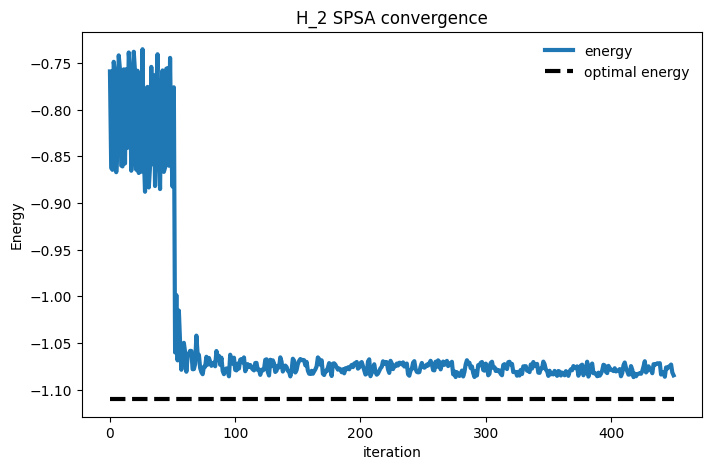

In [207]:
plot_convergence(values_hist, 3)

In [ ]:
exact_energies = []
for dist in dists:
    temp_res, min_energy, nuclear_repulsion_energy = get_exact_energies(dist)
    calculation_base_energy = min_energy - nuclear_repulsion_energy
    exact_energies.append([calculation_base_energy, min_energy, nuclear_repulsion_energy])

In [ ]:
target_energies = [exact_energies_i[1] for exact_energies_i in exact_energies]

In [ ]:
calculated_energies = []
for i, dist in enumerate(dists):
#     paulis, coeffs = get_paulis_and_coeffs(dist)
    cur_values = values_hist[dist]
    calculated_energy = min(cur_values).real + all_coeffs[i][0] + exact_energies[i][2]
    calculated_energies.append(calculated_energy)

In [ ]:
plot_energies(target_energies, calculated_energies, dists)